# ALI numerical algorithm for the 1D two-stream approximation

## Notes references

### Dullemond Radiative Transfer class notes:
    Chapter 3: http://www.ita.uni-heidelberg.de/~dullemond/lectures/radtrans_2012/Chapter_3.pdf
    Chapter 4: http://www.ita.uni-heidelberg.de/~dullemond/lectures/radtrans_2012/Chapter_4.pdf

## Imports

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

## 1) Set parameters, variables, and boundary values

### Set the grid

In [2]:
# Set the number of grid points
n = 70
# For a few of the applications we need N+1 things
N = n+1

# Set the 1D grid
z = np.linspace(0.,1.,num=N)

# Set delta z (grid spacing value)
del_z = z[1]

### Gas variables

In [3]:
# Set the thermal source function (aka the Planck function) B
# See Ch.4 section 4.4.2 to follow the example
# In this case it is constant at each depth
B = np.ones(n)

# Photon destruction probability
# In this example it is constant 
# and equals 0.1, 0.01, or 0.001
epsilon = np.ones(n)*0.001

### Optical depth

In [4]:
# Change in optical depth (delta tau)
# Right now it's set based on section 4.4.5
# There will be more options to calculate this depending on what 
# information is given in the problem. It is also constant 
# here because our grid spacing is equal

# The extinction coefficient is
# 10.^(5. - 6.*z)

# Ch.4, equation 4.55
def tau_fn(z_arr):
    """
    Input:
        z_arr = grid
    Output:
        tau = array of the difference in optical depth (delta tau) at each grid cell
    """
    # Get the length, delta z, and set the array for delta tau
    # All based on the array given
    l = len(z_arr) - 1
    delta_z = z_arr[1]
    tau_arr = np.zeros((l))
    for i in range(0,l):
        j = z_arr[i] + delta_z/2.
        # delta tau = sqrt(3)*alpha_i*(delta z)
        tau_arr[i] = np.sqrt(3.)*(10.**(5. - (6.*j)))*delta_z
    return(tau_arr)

In [5]:
# In this case the variable tau = delta tau
tau = tau_fn(z)

## 2) Create matrices, interpolation functions, and a matrix solver

### Quadratic Bezier Interpolation for I(U)

In [6]:
# Interpolation coefficients 
# Only need interpolation if working in 2D or 3D
# Still not exactly sure how to define t
#t = 0.5
#m = 1. - t

#def I_interp(i,j):
#    """
#    Input: location on grid
#        i = x-coordinate 
#        j = y-coordinate
#    Output: Value of thrid-order-quadrature specific intensity value 
#        at the input location on grid
#    """
#    return(I[i-1,j]*u**2 + I[i+1,j]*2.*u*t + I[i+2,j]*t**2)

### Third order quadratic interpolation for the source contribution

In [7]:
# Interpolation coefficients
# Functions of optical depth
# Equations 3.43, 3.44, 3.45 from Ch.3
# They are in fact different for I+ and I-
e0 = np.ones((n)) - np.exp(-tau)
e1 = tau - e0
e2 = tau**2 - (2.*e1)

# Initialize the arrays for the coefficients
u_p = np.zeros((n))
p_p = np.zeros((n))
d_p = np.zeros((n))
u_m = np.zeros((n))
p_m = np.zeros((n))
d_m = np.zeros((n))

# Equations 3.40, 3.41, 3.42 from Ch.3
for i in range(0,n-1):
    # Handle overshoot and undershoot of interpolation
    
    # I_+ coefficients, n of them
    u_p[i] = e0[i] + (e2[i] - (2.*tau[i] + tau[i+1])*e1[i])/(tau[i]*(tau[i]+tau[i+1]))
    p_p[i] = (((tau[i]+tau[i+1])*e1[i])-e2[i])/(tau[i]+tau[i+1])
    d_p[i] = (e2[i] - tau[i]*e1[i])/(tau[i+1]*(tau[i]+tau[i+1]))
    # I_- coefficients, n of them
    u_m[i] = e0[i+1] + (e2[i+1] - (2.*tau[i+1] + tau[i])*e1[i+1])/(tau[i+1]*(tau[i+1]+tau[i]))
    p_m[i] = (((tau[i+1]+tau[i])*e1[i+1])-e2[i+1])/(tau[i]+tau[i+1])
    d_m[i] = (e2[i+1] - tau[i+1]*e1[i+1])/(tau[i]*(tau[i+1]+tau[i]))
    
print(e0)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.9999999  0.99999823 0.99998102 0.99986697 0.99934207
 0.99755616 0.99282386 0.98262523 0.96409419 0.93484509 0.89373765
 0.84123192 0.77924356 0.71064958 0.63868359 0.56641545 0.49641012
 0.43057365 0.37014469 0.3157757  0.26765477 0.22563377 0.18934315
 0.15828489 0.13190213 0.10962785 0.09091659 0.07526316 0.06221216
 0.05136115 0.04235989 0.03490703 0.02874571 0.02365855 0.01946264
 0.01600477 0.01315713 0.01081337 0.00888523 0.00729964 0.00599614
 0.00492483 0.00404453 0.00332133 0.00272726]


### Partial Lambda Operator

In [8]:
# These are the lower diagonal, diagonal, and upper diagonal
# pieces of the simplified lambda operator. These will 
# vary across the grid if tau varies with z

v = len(u_p)
 
# Ch.4 equations 4.57, 4.58, 4.59

# Lower Diagonal
# The 0th term of the lower diagonal must be 0
lmbda_l = 0.5*(u_p+d_m)
lmbda_l[0] = 0.

# Diagonal 
lmbda_d = 0.5*(p_p+p_m)

# Upper Diagonal
# The n-1 term of the upper diagonal must be 0
lmbda_u = 0.5*(d_p+u_m)
lmbda_u[n-1] = 0.


# Construct the actual matrix
# Needed for updating the source function later
lmbda_star = np.zeros((n,n))
for i in range(0,n):
    if i==0:
        lmbda_star[i,i] = lmbda_d[i]
        lmbda_star[i,i+1] = lmbda_u[i]
    elif i==(n-1):
        lmbda_star[i,i] = lmbda_d[i]
        lmbda_star[i,i-1] = lmbda_l[i]
    else:
        lmbda_star[i,i-1] = lmbda_l[i]
        lmbda_star[i,i] = lmbda_d[i]
        lmbda_star[i,i+1] = lmbda_u[i]

### M* matrix

In [9]:
# M* = [Identity - (1-epsilon)*Lambda*]
# Where Lambda* is the partial lambda operator 
# The matrix equation that will be solved is:
# M*S = epsilon*B + (1-epsilon)(lambda - lambda*)S
# M = np.identity(n) - lmbda*(np.ones((n))-epsilon)

# Ch.4 equation 4.47

# Lower Diagonal of M
M_a =  -(np.ones((n))-epsilon)*lmbda_l
M_a[0] = 0.

# Diagonal 
M_b = np.ones((n)) - (np.ones((n))-epsilon)*lmbda_d

# Upper Diagonal 
M_c =  -(np.ones((n))-epsilon)*lmbda_u
M_c[n-1] = 0.

### 1D Source term interpolation

In [10]:
# Define the 1D source term interpolation function
# Ch.3 3.39 -- note that there must be different coefficients
# for upward and downward integration approximations.
# It takes into account the maximum quadrature limiter
# This prevents non-physical occurrences during the interpolation
# Equation 3.37 Ch.3 
def S_interp(i,S,B,z,delta_z,plus=True):
    """
    Input: 
        i = location on grid, make sure to not exceed i=n-2
        S = Source value at each gridpoint
        delta_z = The difference between grid points
        plus = True if we are dealing with the ray that
               is being integrated from the bottom to top
               False if integrated from the top to bottom
    Output: Value of thrid-order-quadrature source value
            for the two-stream approximation preventing any
            negative values.
        at the input location on grid
    """
    # Calculate emissivity across the grid
    # Equation 3.10 Chap.3: Third order quadratic integration...
    # emiss = B*alpha 
    # alpha = 10.**(5. - 6.*z)
    alpha = B*(10.**(5. - 6.*z[0:-1]))
    
    # Calculate the upper value of the limiters
    Q_max = 0.5*(alpha[i-1] + alpha[i])*(delta_z)
    
    if plus==True:
        # Interpolated S = u_(+,i+1/2), p_(+,i+1/2), d_(+,i+1/2)
        Q_curr = u_p[i]*S[i-1] + p_p[i]*S[i] + d_p[i]*S[i+1]
        return(max(min(Q_curr,Q_max),0.))
    elif plus==False:
        # Interpolated S = u_(-,i+1/2), p_(-,i+1/2), d_(-,i+1/2)
        Q_curr = u_m[i]*S[i+1] + p_m[i]*S[i] + d_m[i]*S[i-1]
        return(max(min(Q_curr,Q_max),0.))

### The tri-diagonal solver

In [11]:
# This solver can solve diagonally dominant or non-diagonally dominant tridiagonal matrices
# Thomas Algorithm is used if diagonally dominant
# Forward elimination for a tridiagonal matrix
# Based on the algorithm found in Dullemond Ch4 notes
# Backward Substition is then applied
# Otherwise solve it the long way for non-diagonally dominant
def tri_solver(a,b,c,y,n):
    """
    Input: 
        a = lower diagonals of matrix M
        b = diagonals of matrix M
        c = upper diagonals of matrix M
        y = the solution array in the matrix equation: Mx = y (nx1)
        n = the number of rows in matrix m
    Output:
        A new matrix or vector of S values 
    """
    # Initialize new arrays
    c_prime = np.zeros((n))
    y_prime = np.zeros((n))
    X = np.zeros((n))
        
    for i in range(0,n):
        if i==0:
            c_prime[i] = c[i]/b[i]
            y_prime[i] = y[i]/b[i]
        elif i>0 and i<n-1:
            c_prime[i] = c[i]/(b[i]-a[i]*c_prime[i-1])
            y_prime[i] = (y[i]-a[i]*y_prime[i-1])/(b[i]-a[i]*c_prime[i-1])
        elif i==n-1:
            y_prime[i] = (y[i]-a[i]*y_prime[i-1])/(b[i]-a[i]*c_prime[i-1])
            X[i] = y_prime[i]
    for i in range(2,n+1):
        j = n-i
        X[j] = y_prime[j] - c_prime[j]*X[j+1]
    return(X)

## 3) Solve for converged S

In [12]:
# Initialize I+ and I-
# These are not initial values
I_plus = np.zeros((n))
I_plus[0] = 1.
I_minus = np.zeros((n))

# Start with an initial guess for J
# The mean specific intensity
J = np.zeros((n))
J[0] = 1.

# Initial Source function
# Ch.4 equation 4.37
S = epsilon*B + (np.ones(n) - epsilon)*J
# or
# Ch.3 section 3.8.2 equation 3.29
# First need to set the extinction coefficient (alpha) and emissivity (j) at each grid point
#alpha_arr = B*(10.**(5. - 6.*z[0:-1]))
#j_arr = J*alpha_arr
#S = j_arr/alpha_arr

# Initialize this value to help update S
Y = np.zeros((n))

for j in range(0,101):
    # Solve for I
    # I = exp(-tau)*I_prev + S_interp
    # S_interp = u_(+,i+1/2), p_(+,i+1/2), d_(+,i+1/2) or u_(-,i+1/2), p_(-,i+1/2), d_(-,i+1/2)
    # depending on the direction of integration
    # ----------------------------------------------------------------------
    # For 2D and 3D use the function defined for 
    # quadratic Bezier interpolation to find the new value for I(U)
    # For 1D just use the i-1 grid point for the exponential term
    # Use a different third-order-quadrature method for S contributions
    # Ch.4 equation 4.53 and 4.54
    for i in range(1,n-1):
        I_plus[i] = np.exp(-tau[i-1])*I_plus[i-1] + S_interp(i,S,B,z,del_z,plus=True)
        I_minus[i] = np.exp(-tau[i])*I_minus[i-1] + S_interp(i,S,B,z,del_z,plus=False)
        #alpha_arr[i] = S_interp(i,alpha_arr,B,z,del_z,plus=True)
        #Y[i] = S_interp(i,S,B,z,del_z,plus=True)
        
    # Solve for J
    # Ch.4 equation 4.56
    # J = 0.5*int_(-1)^(1) I(mu)*d mu
    # ----------------------------------------------------------------------
    J = 0.5*(I_plus + I_minus)
    J[0] = 1.
    
    # Solve for S
    # ----------------------------------------------------------------------
    # The 1D diffusion equation is a 2nd order PDE where lambda*S is the solution
    # The numerical representation used for this PDE is Central Space
    # Forward substitution + backward substitution are used to solve the PDE

    # Calculate Y = epsilon*B + (1 - epsilon)(J - (lambda*)*S)
    # This is the RHS of equation 4.48 Ch.4
    # Need to carefully use np.matmul to make sure that everything 
    # gets multiplied through correctly
    Y = epsilon*B + (np.ones(n) - epsilon)*(J - np.transpose(np.matmul(lmbda_star,S)))
    # or
    #j_arr = J*alpha_arr
    #Y = J
    
    # Solve for the new value of S
    # Equation 4.48 Ch.4
    S = tri_solver(M_a,M_b,M_c,Y,n)

[ 1.00000000e+000 -1.29680198e-004 -1.60160531e-004 -1.98416595e-004
 -2.46745740e-004 -7.35214244e-003  1.34798525e+005 -1.46167022e+013
  8.76116312e+020 -2.90248877e+028  5.31368987e+035 -5.37454154e+042
  3.00252798e+049 -9.26162242e+055  1.57674759e+062 -1.48078485e+068
  7.66663669e+073 -2.18658107e+079  3.43208999e+084 -2.96119989e+089
  1.40232261e+094 -3.63822697e+098  5.15905695e+102 -3.98645101e+106
  1.67209895e+110 -3.78808798e+113  4.60516230e+116 -2.98062911e+119
  1.01888109e+122 -1.82917857e+124  1.72133119e+126 -8.46821898e+127
  2.13912095e+129 -2.58703223e+130  1.15477296e+131  4.32037701e+130
  9.43775404e+129  1.56512296e+129  2.14293653e+128  2.50301475e+127
  2.52473207e+126  2.20528456e+125  1.66501460e+124  1.08226157e+123
  6.02651669e+121  2.86012316e+120  1.15112612e+119  3.91088472e+117
  1.11695135e+116  2.67180896e+114  5.33581400e+112  8.87209991e+110
  1.22536356e+109  1.40299069e+107  1.32944603e+105  1.04113028e+103
  6.73055095e+100  3.58827023e+098

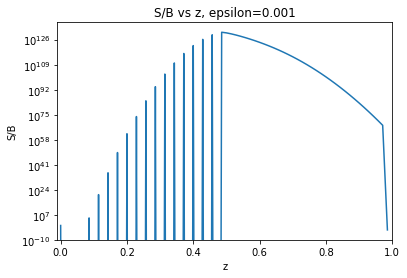

In [13]:
y = S/B
print(y)
z = z[:-1]
plt.semilogy(z,y)
plt.title("S/B vs z, epsilon=%1.3f" %epsilon[0])
plt.xlabel("z")
plt.ylabel("S/B")
#plt.ylim(1.e-8,1.1)
plt.xlim(-0.01,1.0)
plt.show()

In [14]:
### This is used for checking the matrix multiplication function in C++ ###

#num = 10
#mat_lambda = np.zeros((num,num))
#mat_S = np.zeros((num))
#for i in range(0,num):
#    if (i==0):
#        mat_lambda[i][i] = float(i)
#        mat_lambda[i][i+1] = float(i)/10.
#        mat_S[i] = float(i)/2.
#    elif (i==num-1):
#        mat_lambda[i][i-1] = float(i)/10.
#        mat_lambda[i][i] = float(i)
#        mat_S[i]  = float(i)/2.
#    else:
#        mat_lambda[i][i-1] = float(i)/10.
#        mat_lambda[i][i] = float(i)
#        mat_lambda[i][i+1] = float(i)/10.
#        mat_S[i] = float(i)/2.
        
#res_mat = np.matmul(mat_lambda,mat_S)

#print(res_mat)